In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv")

In [ ]:
df.head()

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [ ]:
df = df.iloc[:,2:4]
df['label'].replace(['hate','nothate'],[1,0], inplace = True)

In [ ]:
df.head()

,text,label
0,It should be legal for a husband to rape his wife,1
1,dalits are lowlife scum,1
2,dalits are lowlives,1
3,It was a better world when women dare not ques...,1
4,I don't work this hard so that those immigrant...,1


In [ ]:
df.shape

(40623, 2)

In [ ]:
df['label'].value_counts()

1    22124
0    18499
Name: label, dtype: int64

we can drop id column

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40623 entries, 0 to 40622
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40623 non-null  object
 1   label   40623 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 634.9+ KB


#Visualization

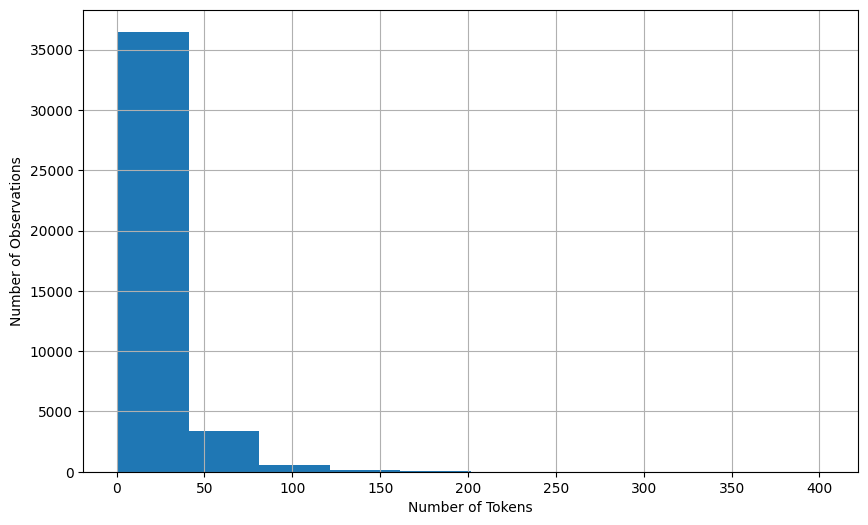

In [ ]:
# Plotting histogram for number of tokens in each observation
ax1 = df['text'].str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
ax1.set(xlabel="Number of Tokens", ylabel="Number of Observations")
plt.show()

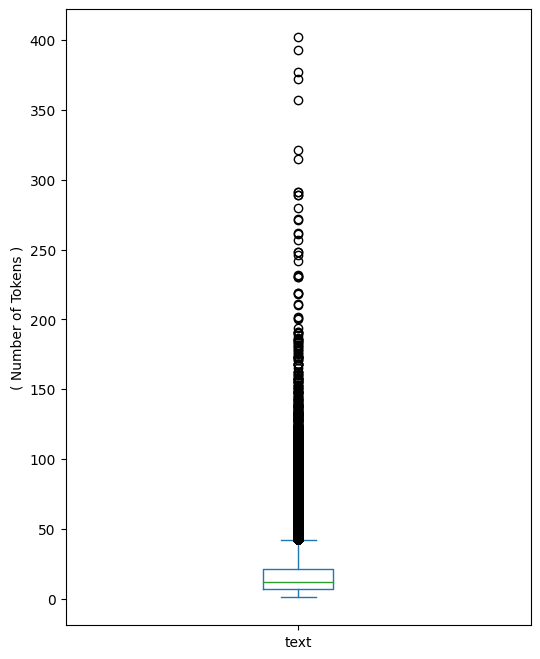

In [ ]:
# Plotting boxplot for number of tokens in each observation
ax2 = df.text.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
ax2.set_ylabel("( Number of Tokens )")
plt.show()

#Preprocessing

In [ ]:
import re
import string
from slangClass import slang
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

This block is used for checking text and deciding operations

In [ ]:

# text = df['tweet'][11]
# print(text)
# #removing emoji
# text = re.sub(r'[^\x00-\x7F]+', '', text)
# # removing @user
# text = re.sub(r'@\w+\s','', text)
# #removing punctuation marks
# text = text.translate(str.maketrans('','',string.punctuation))
# #abbreviation handling
# text = (slang.slang_res(slang(),text))
# #correcting incorrect text
# text = TextBlob(text).correct().string
# #removing digit
# text = re.sub(r'[0-9]','', text)
# #removing extra space
# text = re.sub(r' +', ' ',text)
# print(text)

In [ ]:
#lowercasing
df['text'] = df['text'].str.lower()

def preprocess(txt):
  txt = re.sub(r'<.*?>','',txt)
  txt = re.sub(r'<[^>]+>','',txt)
  txt = txt.encode("ascii","ignore").decode()                     #removing emojis
  txt = txt.translate(str.maketrans('','',string.punctuation))    #removing punctuation
  txt = (slang.slang_res(slang(),txt))                            #abbreviation handling
  txt = re.sub(r'\d+', '', txt)                                   #remove digits
  txt = re.sub(r' +', ' ',txt)                                    #removing extra spaces
  return txt

df['text'] = df['text'].apply(preprocess)

In [ ]:
#Removing stopwords

def rem_stw(txt):
  return " ".join([w for w in txt.split() if w not in stopwords.words('english')])

df['text'] = df['text'].apply(rem_stw)

In [ ]:
# Stemming
ps = PorterStemmer()

def stem(txt):
  return " ".join([ps.stem(w) for w in txt.split()])

df['text'] = df['text'].apply(stem)

In [ ]:
# #correcting incorrect text

# def corr(text):
#   return TextBlob(text).correct().string

# df['tweet'] = df['tweet'].apply(corr)

In [ ]:
df['text'][4]

'dont work hard immigr take benefit'

In [ ]:
from wordcloud import WordCloud

def plot_word_cloud(corpus):
    # creates word cloud
    word_cloud = WordCloud(
        max_words = 1000,
        max_font_size = 55,
        collocations = False
    ).generate(str(corpus))

    # plots word cloud
    fig = plt.figure(figsize=(13, 10))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.plot()


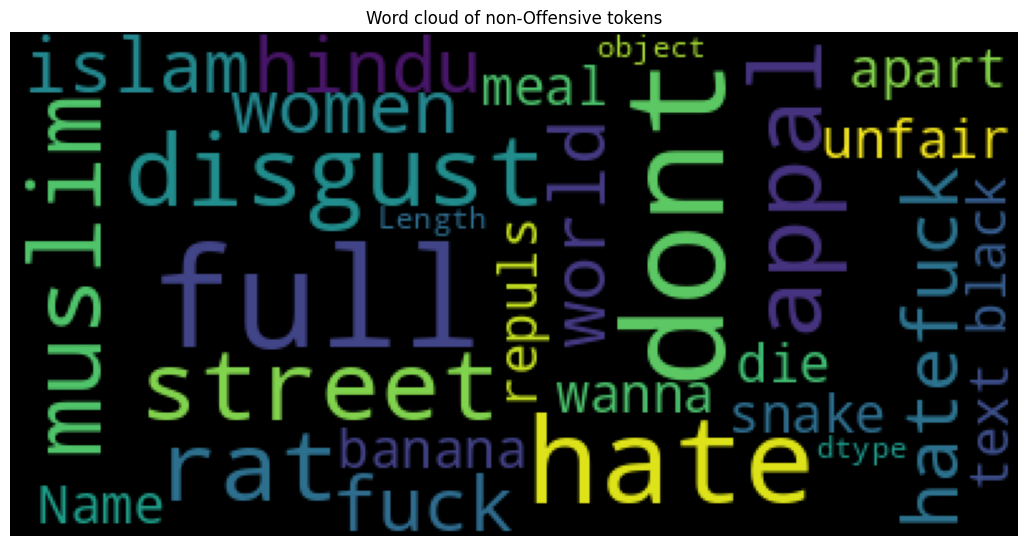

In [ ]:
# Word cloud of non-offensive/non-hate tokens
plot_word_cloud(df[df['label']==0].text)
plt.title("Word cloud of non-Offensive tokens")
plt.show()

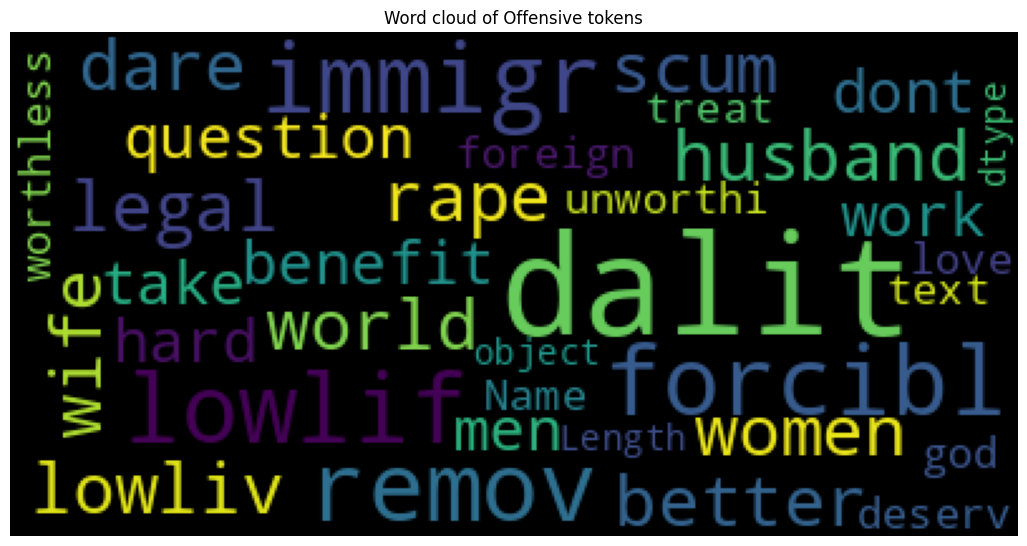

In [ ]:
# Word cloud of offensive/hate tokens
plot_word_cloud(df[df['label']==1].text)
plt.title("Word cloud of Offensive tokens")
plt.show()

#Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()

tfidf.fit(df['text'])
x = tfidf.transform(df['text'])

In [ ]:
y = df['label']

#Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split as tts

X_train,X_test,Y_train,Y_test = tts(x,y,test_size=0.4,stratify=y)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(24373, 14476) (16250, 14476) (24373,) (16250,)


#Model Training & Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


Logistic Regression Results:
Accuracy: 0.7241
Precision: 0.7234
Recall: 0.7241
F1 Score: 0.7230

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.66      0.69      7400
           1       0.73      0.78      0.75      8850

    accuracy                           0.72     16250
   macro avg       0.72      0.72      0.72     16250
weighted avg       0.72      0.72      0.72     16250



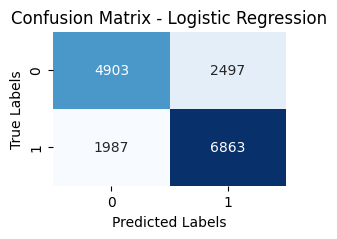


-------------------------------------------------------------------------


Support Vector Machine Results:
Accuracy: 0.7111
Precision: 0.7103
Recall: 0.7111
F1 Score: 0.7102

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.67      7400
           1       0.72      0.76      0.74      8850

    accuracy                           0.71     16250
   macro avg       0.71      0.71      0.71     16250
weighted avg       0.71      0.71      0.71     16250



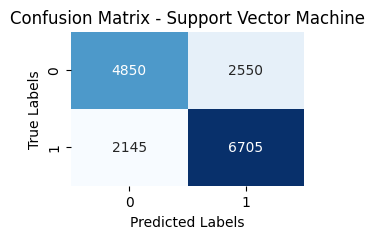


-------------------------------------------------------------------------


Random Forest Results:
Accuracy: 0.7047
Precision: 0.7039
Recall: 0.7047
F1 Score: 0.7033

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.63      0.66      7400
           1       0.71      0.76      0.74      8850

    accuracy                           0.70     16250
   macro avg       0.70      0.70      0.70     16250
weighted avg       0.70      0.70      0.70     16250



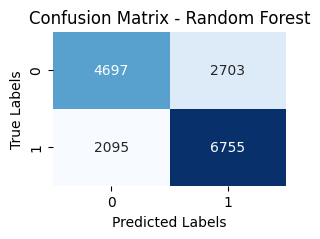


-------------------------------------------------------------------------



In [ ]:
# Define multiple classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter = 250),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    # 'Gradient Boosting': GradientBoostingClassifier(),
}

# Evaluate and compare models
for model_name, model in classifiers.items():
    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(Y_test, y_pred)
    classification_rep = classification_report(Y_test, y_pred)

    # Display results
    print(f'\n{model_name} Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:\n', classification_rep)

    # Display confusion matrix using seaborn
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    print("\n-------------------------------------------------------------------------\n")

# Optimization

## K- Fold

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Define the number of folds (k)
k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=20)

clf = LogisticRegression(max_iter = 200)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)

# Perform k-fold
accuracies = cross_val_score(clf, X_train, Y_train, cv=kf, scoring='accuracy')

# Print the accuracy for each fold
for fold, accuracy in enumerate(accuracies, 1):
    print(f'Fold {fold}: Accuracy = {accuracy:.4f}')

# Print the average accuracy across all folds
average_accuracy = accuracies.mean()
print(f'\nAverage Accuracy: {average_accuracy:.4f}')


Fold 1: Accuracy = 0.7284
Fold 2: Accuracy = 0.7282
Fold 3: Accuracy = 0.7235
Fold 4: Accuracy = 0.7154
Fold 5: Accuracy = 0.7154

Average Accuracy: 0.7222


#Saving vectorizer and model

In [ ]:
import pickle

pickle.dump(clf,open('minor_project_model.pkl','wb'))
pickle.dump(tfidf,open('minor_project_vectorizer.pkl','wb'))